gen	nevals	min     	mean 
0  	50    	0.135912	14227
1  	43    	0.1442  	19275.2
2  	39    	0.144857	0.341836
3  	38    	0.144857	136676  
4  	41    	0.104334	0.345204
5  	38    	0.104319	0.217599
6  	39    	0.104319	0.213772
7  	38    	0.105262	0.220459
8  	37    	0.104643	0.14425 
9  	40    	0.101521	2.10171 
10 	39    	0.101239	3.0851  
11 	37    	0.101239	3.10664 
12 	44    	0.101123	2.11996 
13 	41    	0.101049	1.15522 
14 	42    	0.101084	0.112152
15 	42    	0.100932	0.125911
16 	29    	0.100916	0.101211
17 	39    	0.100846	0.101193
18 	34    	0.100691	0.101044
19 	36    	0.100691	0.100945
20 	40    	0.100596	0.10097 
21 	43    	0.100568	0.100843
22 	31    	0.100402	0.100716
23 	41    	0.100373	0.100677
24 	40    	0.100426	0.100598
25 	39    	0.100389	0.10055 
26 	38    	0.100234	0.100465
27 	34    	0.100232	0.100419
28 	38    	0.10023 	0.100372
29 	36    	0.100197	0.100301
30 	41    	0.100211	0.100292
Best PID Parameters: Kp=78.33, Ki=-68.42, Kd=95.45


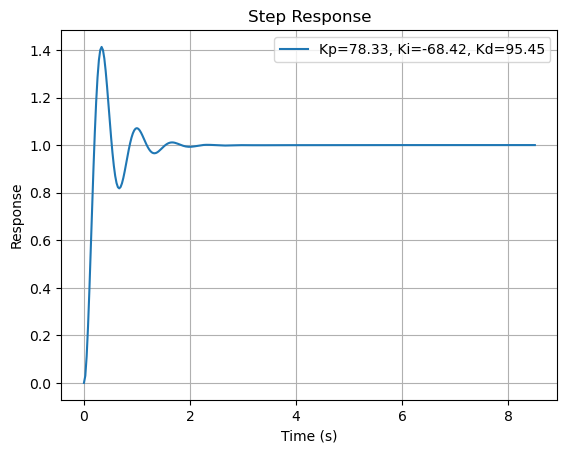

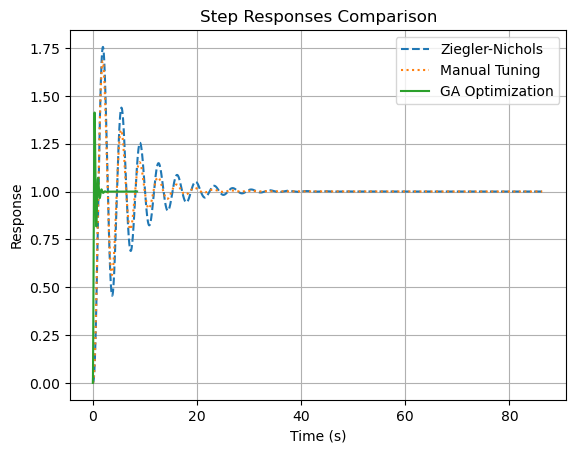

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import deap.base
import deap.creator
import deap.tools
import deap.algorithms
from control import tf, step_response, feedback, dcgain

# Choose cost function (Set to 1-6)
cost_function_choice = 1  # 1=ITAE, 2=ISE, 3=ITSE, 4=SSE, 5=Overshoot, 6=Settling Time

# Define System Transfer Function
def system_response(Kp, Ki, Kd, show_plot=False):
    """
    Simulates the closed-loop system with a PID controller and computes various cost metrics.

    Returns:
        tuple: Selected cost function value, along with secondary metrics for logging.
    """
    s = tf([1, 0], [1])  # Laplace variable
    Ti = max(Ki, 0.1)  # Avoid division by zero

    # Plant Transfer Function (Third-order System)
    P = 1 / (s**3 + 6*s**2 + 5*s)

    # PID Controller Transfer Function
    C = Kp + Ti / s + Kd * s

    # Closed-loop system
    G = feedback(C * P, 1)
    t, y = step_response(G)

    # Calculate Cost Metrics
    itae = np.trapz(t * np.abs(1 - y), t)  # ITAE
    ise = np.trapz((1 - y) ** 2, t)  # Integral of Squared Error (ISE)
    itse = np.trapz(t * (1 - y) ** 2, t)  # ITSE
    sse = np.abs(1 - y[-1])  # Steady-state error
    overshoot = (np.max(y) - 1) * 100  # Percent Overshoot
    settling_time = t[np.where(np.abs(1 - y) < 0.02)[0][0]] if np.any(np.abs(1 - y) < 0.02) else t[-1]  # 2% Settling Time

    # Choose Cost Function
    cost_dict = {
        1: itae,
        2: ise,
        3: itse,
        4: sse,
        5: overshoot,
        6: settling_time
    }
    cost_value = cost_dict.get(cost_function_choice, itae)  # Default to ITAE

    # Show Step Response
    if show_plot:
        plt.plot(t, y, label=f'Kp={Kp:.2f}, Ki={Ki:.2f}, Kd={Kd:.2f}')
        plt.xlabel('Time (s)')
        plt.ylabel('Response')
        plt.title('Step Response')
        plt.legend()
        plt.grid()
        plt.show()

    return cost_value, itae, ise, itse, sse, overshoot, settling_time

# Compare Step Responses
def compare_step_responses(best_pid):
    """Compares GA-optimized PID with Ziegler-Nichols and Manual Tuning."""
    Kp_zn, Ki_zn, Kd_zn = 0.6 * 30, 0.5 * (2 * np.pi / np.sqrt(5)), 0.125 * (2 * np.pi / np.sqrt(5))
    Kp_manual, Ki_manual, Kd_manual = Kp_zn, Ki_zn, 3 * Kd_zn
    Kp_ga, Ki_ga, Kd_ga = best_pid

    s = tf([1, 0], [1])

    def get_response(Kp, Ki, Kd):
        P = 1 / (s**3 + 6*s**2 + 5*s)
        C = Kp + max(Ki, 0.1) / s + Kd * s
        G = feedback(C * P, 1)
        return step_response(G)

    t_zn, y_zn = get_response(Kp_zn, Ki_zn, Kd_zn)
    t_manual, y_manual = get_response(Kp_manual, Ki_manual, Kd_manual)
    t_ga, y_ga = get_response(Kp_ga, Ki_ga, Kd_ga)

    plt.figure()
    plt.plot(t_zn, y_zn, '--', label='Ziegler-Nichols')
    plt.plot(t_manual, y_manual, ':', label='Manual Tuning')
    plt.plot(t_ga, y_ga, '-', label='GA Optimization')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.title('Step Responses Comparison')
    plt.grid()
    plt.show()

# Genetic Algorithm Setup
deap.creator.create("FitnessMin", deap.base.Fitness, weights=(-1.0,))
deap.creator.create("Individual", list, fitness=deap.creator.FitnessMin)

def init_individual():
    """Initializes an individual with random PID parameters."""
    return deap.creator.Individual([random.uniform(0, 100) for _ in range(3)])

def evaluate(ind):
    """Evaluates the fitness of an individual."""
    cost, *_ = system_response(ind[0], ind[1], ind[2])
    return (cost,)

# GA Parameters
POP_SIZE = 50
CX_PROB = 0.7
MUT_PROB = 0.2
N_GEN = 30

# Setup Toolbox
toolbox = deap.base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", deap.tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", deap.tools.cxBlend, alpha=0.5)
toolbox.register("mutate", deap.tools.mutGaussian, mu=0, sigma=3, indpb=0.2)
toolbox.register("select", deap.tools.selTournament, tournsize=3)

# Run Genetic Algorithm
def run_ga():
    """Runs the genetic algorithm to optimize PID parameters."""
    pop = toolbox.population(n=POP_SIZE)
    hof = deap.tools.HallOfFame(1)
    stats = deap.tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("mean", np.mean)

    pop, log = deap.algorithms.eaSimple(
        pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB, ngen=N_GEN,
        stats=stats, halloffame=hof, verbose=True)

    best_ind = hof[0]
    print(f"Best PID Parameters: Kp={best_ind[0]:.2f}, Ki={best_ind[1]:.2f}, Kd={best_ind[2]:.2f}")
    
    # Show final response
    system_response(best_ind[0], best_ind[1], best_ind[2], show_plot=True)
    
    # Compare with other methods
    compare_step_responses(best_ind)

if __name__ == "__main__":
    run_ga()
